# Import packages

In [1]:
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
!pip install category_encoders
from category_encoders import OrdinalEncoder, OneHotEncoder
from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, roc_auc_score, plot_confusion_matrix
from sklearn.inspection import permutation_importance
from joblib import dump

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Load Data

In [2]:
# Data already wrangled. Ready for modeling
df = pd.read_csv('https://raw.githubusercontent.com/n8mcdunna/baseball_on_base_predictor/master/data/top_50_batters.csv')

# Modeling

## Baseline

In [3]:
print('Baseline:\n', round(df['result'].value_counts(normalize = True)*100, 3),'%')


Baseline:
 Out        63.908
On Base    36.092
Name: result, dtype: float64 %


## Train - test split

In [4]:
target = 'result'
y = df[target]
X = df.drop(columns= target)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42)

## Random Forest 59.23


In [5]:
rf_model = make_pipeline(
    OrdinalEncoder(),
    RandomForestClassifier(
        n_jobs= -1,
        verbose= 1),
);
rf_model.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   23.7s finished


Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['p_throws', 'stand', 'away_team',
                                      'home_team', 'venue_name', 'weather',
                                      'wind_direction', 'batter', 'pitcher'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'p_throws',
                                          'data_type': dtype('O'),
                                          'mapping': R      1
L      2
NaN   -2
dtype: int64},
                                         {'col': 'stand',
                                          'data_type': dtyp...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
              

In [6]:
score = cross_val_score(rf_model, X_train, y_train, n_jobs = -1, verbose = 1, scoring= 'accuracy')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.8min finished


In [7]:
print('CV accuracy score:', score.mean())

CV accuracy score: 0.5842877861368875


## XGBoost





In [8]:
xgb_model = make_pipeline(
    OrdinalEncoder(),
    XGBClassifier()
)
xgb_model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['p_throws', 'stand', 'away_team',
                                      'home_team', 'venue_name', 'weather',
                                      'wind_direction', 'batter', 'pitcher'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'p_throws',
                                          'data_type': dtype('O'),
                                          'mapping': R      1
L      2
NaN   -2
dtype: int64},
                                         {'col': 'stand',
                                          'data_type': dtyp...
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
                       

In [9]:
xgb_score = cross_val_score(xgb_model, X_train, y_train, scoring= 'accuracy', verbose= 1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   33.0s finished


In [10]:
print('XGB training accuracy:', xgb_score.mean())

XGB training accuracy: 0.6400797278661299


In [26]:
perm_imp = permutation_importance(xgb_model, X_test, y_test, random_state= 42)

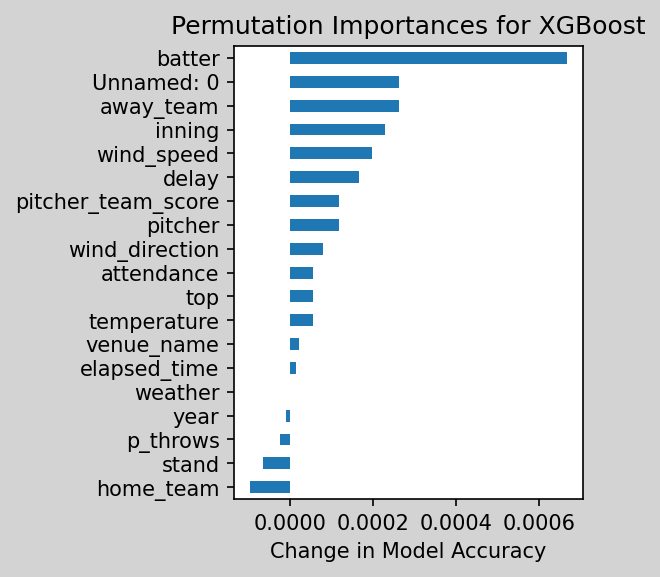

In [27]:
data = {
    'importances_mean' : perm_imp['importances_mean'],
    'importances_std' : perm_imp['importances_std']
}

perm_imp_df = pd.DataFrame(data, index= X_test.columns)
perm_imp_df.sort_values(by = 'importances_mean', ascending= True, inplace= True)

fig, ax = plt.subplots()
fig.set_facecolor('lightgrey')
fig.set_figheight(4)
fig.set_figwidth(3)
perm_imp_df['importances_mean'].plot(kind= 'barh')
plt.xlabel('Change in Model Accuracy')
plt.title('Permutation Importances for XGBoost')
plt.rcParams['figure.dpi'] = 150

plt.show();

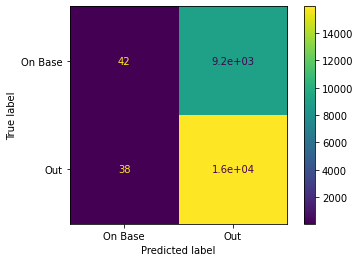

In [14]:
plot_confusion_matrix(xgb_model, X_test, y_test)
plt.show()

### Feature Importances

In [13]:
importances = xgb_model.named_steps['xgbclassifier'].feature_importances_

In [15]:
feat_imp = pd.Series(importances, index= X_train.columns).sort_values()

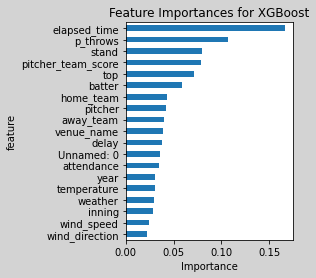

In [16]:
fig, ax = plt.subplots()
fig.set_facecolor('lightgrey')
fig.set_figheight(4)
fig.set_figwidth(3)
plt.xlabel('Importance')
plt.rcParams['figure.dpi'] = 150
plt.title('Feature Importances for XGBoost')
feat_imp.plot(kind= 'barh', xlabel = 'feature', ylabel= 'importance');

## Logistic Regression

In [17]:
lr = make_pipeline(
    OrdinalEncoder(),
    LogisticRegression(n_jobs = -1,
                       verbose = 1),
)
lr.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.2s finished


Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['p_throws', 'stand', 'away_team',
                                      'home_team', 'venue_name', 'weather',
                                      'wind_direction', 'batter', 'pitcher'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'p_throws',
                                          'data_type': dtype('O'),
                                          'mapping': R      1
L      2
NaN   -2
dtype: int64},
                                         {'col': 'stand',
                                          'data_type': dtyp...
Nick Greenwood      1244
Brandon Dixon       1245
NaN                   -2
Length: 1246, dtype: int64}],
                                return_df=True, verbose=0)),
                ('logisticregression',
                 LogisticRegressio

In [18]:
score = cross_val_score(lr, X_train, y_train, n_jobs = -1, verbose = 1, scoring= 'accuracy')
print('Accuracy score:', score.mean())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Accuracy score: 0.6399309822875854


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.5s finished


In [19]:
print('Logistic regression test accuracy:', lr.score(X_test, y_test))

Logistic regression test accuracy: 0.6344307814359381


In [20]:
perm_imp = permutation_importance(lr, X_test, y_test, random_state= 42)

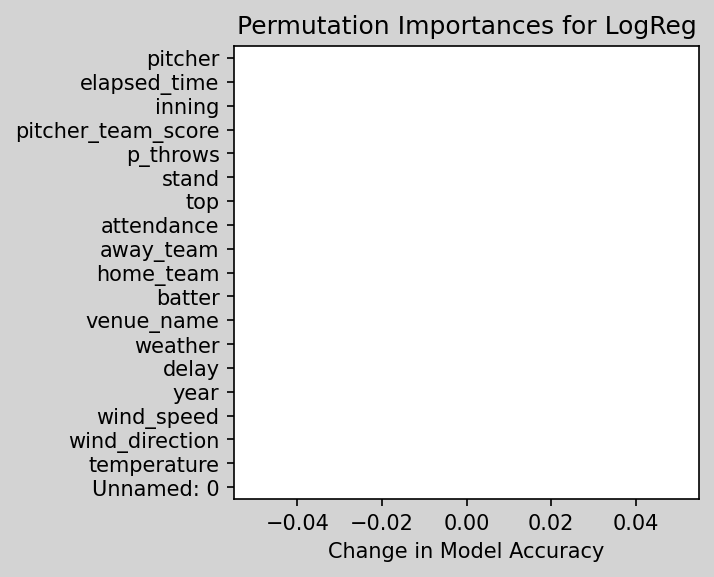

In [24]:
data = {
    'importances_mean' : perm_imp['importances_mean'],
    'importances_std' : perm_imp['importances_std']
}

perm_imp_df = pd.DataFrame(data, index= X_test.columns)
perm_imp_df.sort_values(by = 'importances_mean', ascending= True, inplace= True)

fig, ax = plt.subplots()
fig.set_facecolor('lightgrey')
fig.set_figheight(4)
fig.set_figwidth(4)
perm_imp_df['importances_mean'].plot(kind= 'barh')
plt.xlabel('Change in Model Accuracy')
plt.title('Permutation Importances for LogReg')
plt.rcParams['figure.dpi'] = 150

plt.show();